# Point Colaboratory to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

datapath = '/content/gdrive/My Drive/TESI/' 

Mounted at /content/gdrive


# Import

In [ ]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=39556b3995d3b0efb79084113867cb00607f14fa6cb4d141bdf810954a2766ba
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import tqdm.notebook as tq
import time
from operator import itemgetter
import random
import datetime 
from pandas.api.types import is_numeric_dtype # used for one-hot encoding
import math
import tqdm.notebook as tq
import itertools

# Text mining
from stop_words import get_stop_words
from string import punctuation 
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from scipy import sparse
from scipy.sparse import hstack, vstack

# Sklearn utilities
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

# Sklearn models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings("ignore")

# Neural Netowrk and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn.utils.rnn as rnn_utils

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


# Dataset

In [ ]:
data8 = pd.read_csv(datapath + 'dataset/data8.csv')
# data[['jobid','jobtaskid', 'resid', 'custid', 'sede']] = data[['jobid','jobtaskid', 'resid', 'custid', 'sede']].astype(str)
# data[['flg_trasferta','pay', 'flg_prepagato', 'flg_straordinario']] = data[['flg_trasferta','pay', 'flg_prepagato', 'flg_straordinario']].astype(int)
# data = data.drop(['workdesc'], inplace=False, axis=1)
# data = data8[['cleaned_workdesc', 'tipo_update']]
data = data8[~ data8.cleaned_workdesc.isna()]
data

,qty,day,delay,flg_trasferta,pay,flg_prepagato,flg_straordinario,jobid_100,jobid_107,jobid_110,jobid_118,jobid_119,jobid_123,jobid_125,jobid_126,jobid_135,jobid_157,jobid_158,jobid_173,jobid_174,jobid_175,jobid_177,jobid_178,jobid_179,jobid_187,jobid_203,jobid_209,jobid_210,jobid_227,jobid_231,jobid_2457,jobid_2488,jobid_2509,jobid_2516,jobid_2528,jobid_2534,jobid_2538,jobid_2579,jobid_2580,jobid_2598,...,custid_4340,custid_4343,custid_4361,custid_4370,custid_4375,custid_4379,custid_4391,custid_44,custid_4404,custid_4410,custid_4414,custid_4415,custid_4429,custid_4430,custid_4435,custid_4439,custid_4447,custid_4449,custid_4453,custid_4461,custid_4466,custid_4469,custid_4475,custid_4480,custid_4484,custid_48,custid_59,custid_62,custid_9,sede_1.0,sede_2.0,sede_3.0,sede_4.0,sede_5.0,sede_6.0,sede_7.0,sede_8.0,sede_9.0,cleaned_workdesc,tipo_update
0,5.5,284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,sophos aulss7,1
1,6.0,283,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sophos aulss7,1
2,1.5,282,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,test attiv journeys ato uk ato us analis metri...,0
3,0.5,281,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,call team client fix problemat tracker domain,0
4,0.5,279,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,analis problemat configur pardot tracker domai...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22580,1.5,77,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,document fluss kettl,1
22581,4.0,72,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,document fluss kettl,1
22582,8.0,69,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,document fluss kettl,1
22583,8.0,71,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,upgrad server qlikview install component python,1


## Split

In [ ]:
def split_data(X, y):
    # Divide the dataset into training, validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, 
                                                                random_state=22, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=22, stratify=y_train_val)

    print("Training Set shape: {}".format(X_train.shape))
    print("Validation Set shape: {}".format(X_val.shape))
    print("Training + Validation Set shape: {}".format(X_train_val.shape))
    print("Test Set shape: {}".format(X_test.shape))

    return X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val

In [ ]:
X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val = split_data(data.iloc[:,:-1], data.tipo_update)

Training Set shape: (13080, 1213)
Validation Set shape: (4361, 1213)
Training + Validation Set shape: (17441, 1213)
Test Set shape: (4361, 1213)


In [ ]:
X_train

,qty,day,delay,flg_trasferta,pay,flg_prepagato,flg_straordinario,jobid_100,jobid_107,jobid_110,jobid_118,jobid_119,jobid_123,jobid_125,jobid_126,jobid_135,jobid_157,jobid_158,jobid_173,jobid_174,jobid_175,jobid_177,jobid_178,jobid_179,jobid_187,jobid_203,jobid_209,jobid_210,jobid_227,jobid_231,jobid_2457,jobid_2488,jobid_2509,jobid_2516,jobid_2528,jobid_2534,jobid_2538,jobid_2579,jobid_2580,jobid_2598,...,custid_4326,custid_4340,custid_4343,custid_4361,custid_4370,custid_4375,custid_4379,custid_4391,custid_44,custid_4404,custid_4410,custid_4414,custid_4415,custid_4429,custid_4430,custid_4435,custid_4439,custid_4447,custid_4449,custid_4453,custid_4461,custid_4466,custid_4469,custid_4475,custid_4480,custid_4484,custid_48,custid_59,custid_62,custid_9,sede_1.0,sede_2.0,sede_3.0,sede_4.0,sede_5.0,sede_6.0,sede_7.0,sede_8.0,sede_9.0,cleaned_workdesc
18259,4.0,106,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,svilupp programm didatt fattur prepar cors
21,8.0,274,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,install datacatalog amundsen
883,8.0,265,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,ticket sr incident chang ribalt prod coll user...
9442,7.0,201,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,redazion doc nuov serviz assessment gdpr
8582,0.5,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,sdcs richiest trasfer domin richiest n°
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13825,0.5,152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,gestion ticket duplic info risolt
7027,2.0,216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,fix ui modell storn aplus
2311,8.0,246,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,ordinar
5180,6.0,226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,affianc tommas paolett


In [ ]:
classes, class_count = np.unique(y_train, return_counts=True)
classesv, class_countv = np.unique(y_val, return_counts=True)
classest, class_countt = np.unique(y_test, return_counts=True)
y_labels = ['approvato', 'cambio_commessa']
pd.DataFrame((classes, class_count, class_countv, class_countt), columns=y_labels, index=['Label', 'Trainining', 'Validation', 'Test'])

,approvato,cambio_commessa
Label,0,1
Trainining,11872,1208
Validation,3958,403
Test,3958,403


## RNN data Encoding

Instead of using a word vectorizer, here we will keep a dynamic representation of the description of each rapportino, which will be fed to a RNN. However we still need to encode the text in a numeric format. In this case, I try label encoder, which is the easier approach.

In [ ]:
pd.DataFrame(X_train)

,qty,day,delay,flg_trasferta,pay,flg_prepagato,flg_straordinario,jobid_100,jobid_107,jobid_110,jobid_118,jobid_119,jobid_123,jobid_125,jobid_126,jobid_135,jobid_157,jobid_158,jobid_173,jobid_174,jobid_175,jobid_177,jobid_178,jobid_179,jobid_187,jobid_203,jobid_209,jobid_210,jobid_227,jobid_231,jobid_2457,jobid_2488,jobid_2509,jobid_2516,jobid_2528,jobid_2534,jobid_2538,jobid_2579,jobid_2580,jobid_2598,...,custid_4326,custid_4340,custid_4343,custid_4361,custid_4370,custid_4375,custid_4379,custid_4391,custid_44,custid_4404,custid_4410,custid_4414,custid_4415,custid_4429,custid_4430,custid_4435,custid_4439,custid_4447,custid_4449,custid_4453,custid_4461,custid_4466,custid_4469,custid_4475,custid_4480,custid_4484,custid_48,custid_59,custid_62,custid_9,sede_1.0,sede_2.0,sede_3.0,sede_4.0,sede_5.0,sede_6.0,sede_7.0,sede_8.0,sede_9.0,cleaned_workdesc
18259,4.0,106,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,svilupp programm didatt fattur prepar cors
21,8.0,274,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,install datacatalog amundsen
883,8.0,265,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,ticket sr incident chang ribalt prod coll user...
9442,7.0,201,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,redazion doc nuov serviz assessment gdpr
8582,0.5,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,sdcs richiest trasfer domin richiest n°
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13825,0.5,152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,gestion ticket duplic info risolt
7027,2.0,216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,fix ui modell storn aplus
2311,8.0,246,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,ordinar
5180,6.0,226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,affianc tommas paolett


In [ ]:
# Convert the description in a list of tokens
X_train['cleaned_workdesc'] = X_train['cleaned_workdesc'].apply(lambda x: x.split())
X_train_val['cleaned_workdesc'] = X_train_val['cleaned_workdesc'].apply(lambda x: x.split())
X_val['cleaned_workdesc'] = X_val['cleaned_workdesc'].apply(lambda x: x.split())
X_test['cleaned_workdesc'] = X_test['cleaned_workdesc'].apply(lambda x: x.split())
X_train

,qty,day,delay,flg_trasferta,pay,flg_prepagato,flg_straordinario,jobid_100,jobid_107,jobid_110,jobid_118,jobid_119,jobid_123,jobid_125,jobid_126,jobid_135,jobid_157,jobid_158,jobid_173,jobid_174,jobid_175,jobid_177,jobid_178,jobid_179,jobid_187,jobid_203,jobid_209,jobid_210,jobid_227,jobid_231,jobid_2457,jobid_2488,jobid_2509,jobid_2516,jobid_2528,jobid_2534,jobid_2538,jobid_2579,jobid_2580,jobid_2598,...,custid_4326,custid_4340,custid_4343,custid_4361,custid_4370,custid_4375,custid_4379,custid_4391,custid_44,custid_4404,custid_4410,custid_4414,custid_4415,custid_4429,custid_4430,custid_4435,custid_4439,custid_4447,custid_4449,custid_4453,custid_4461,custid_4466,custid_4469,custid_4475,custid_4480,custid_4484,custid_48,custid_59,custid_62,custid_9,sede_1.0,sede_2.0,sede_3.0,sede_4.0,sede_5.0,sede_6.0,sede_7.0,sede_8.0,sede_9.0,cleaned_workdesc
18259,4.0,106,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[svilupp, programm, didatt, fattur, prepar, cors]"
21,8.0,274,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,"[install, datacatalog, amundsen]"
883,8.0,265,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[ticket, sr, incident, chang, ribalt, prod, co..."
9442,7.0,201,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[redazion, doc, nuov, serviz, assessment, gdpr]"
8582,0.5,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,"[sdcs, richiest, trasfer, domin, richiest, n°]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13825,0.5,152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,"[gestion, ticket, duplic, info, risolt]"
7027,2.0,216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[fix, ui, modell, storn, aplus]"
2311,8.0,246,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,[ordinar]
5180,6.0,226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"[affianc, tommas, paolett]"


In [ ]:
# Sort the datasets according to the lenght of the descriptions
# The reason is that I will use padding in each batch since the dataloader 
# requires equal lenght to all batch samples. Using samples of similar lenght,
# the number of zeros added for padding is smaller

X_train.sort_values(key=lambda x: x.str.len(), ascending=False, inplace=True, by=['cleaned_workdesc'])
X_train_val.sort_values(key=lambda x: x.str.len(), ascending=False, inplace=True, by=['cleaned_workdesc'])
X_val.sort_values(key=lambda x: x.str.len(), ascending=False, inplace=True, by=['cleaned_workdesc'])
X_test.sort_values(key=lambda x: x.str.len(), ascending=False, inplace=True, by=['cleaned_workdesc'])
X_train

,qty,day,delay,flg_trasferta,pay,flg_prepagato,flg_straordinario,jobid_100,jobid_107,jobid_110,jobid_118,jobid_119,jobid_123,jobid_125,jobid_126,jobid_135,jobid_157,jobid_158,jobid_173,jobid_174,jobid_175,jobid_177,jobid_178,jobid_179,jobid_187,jobid_203,jobid_209,jobid_210,jobid_227,jobid_231,jobid_2457,jobid_2488,jobid_2509,jobid_2516,jobid_2528,jobid_2534,jobid_2538,jobid_2579,jobid_2580,jobid_2598,...,custid_4326,custid_4340,custid_4343,custid_4361,custid_4370,custid_4375,custid_4379,custid_4391,custid_44,custid_4404,custid_4410,custid_4414,custid_4415,custid_4429,custid_4430,custid_4435,custid_4439,custid_4447,custid_4449,custid_4453,custid_4461,custid_4466,custid_4469,custid_4475,custid_4480,custid_4484,custid_48,custid_59,custid_62,custid_9,sede_1.0,sede_2.0,sede_3.0,sede_4.0,sede_5.0,sede_6.0,sede_7.0,sede_8.0,sede_9.0,cleaned_workdesc
11031,6.5,175,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[ticket, bi, miriad, vend, nuov, tabell, comun..."
18062,8.0,105,9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[ticket, bi, miriad, unicomm, etl, critical, c..."
9694,4.0,188,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[ticket, bi, miriad, smart, acquisizion, dat, ..."
1951,8.0,252,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[ticket, bi, miriad, jstor, nuov, camp, tabell..."
19650,8.0,78,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[attiv, effettu, ticket, sdcd, creazion, datab..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10956,2.0,170,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,[plenar]
3056,0.5,261,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,[zeene]
8803,1.0,210,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,[riunion]
1221,0.5,271,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,[ticket]


In [ ]:
y_train

18259    0
21       0
883      0
9442     0
8582     0
        ..
13825    0
7027     0
2311     0
5180     0
1242     0
Name: tipo_update, Length: 13080, dtype: int64

In [ ]:
# sort the label vectors in the same way
y_train = y_train.reindex(index=X_train.index)
y_train_val = y_train_val.reindex(index=X_train_val.index)
y_val = y_val.reindex(index=X_val.index)
y_test = y_test.reindex(index=X_test.index)

In [ ]:
y_train

11031    0
18062    0
9694     0
1951     0
19650    0
        ..
10956    0
3056     0
8803     0
1221     0
20605    0
Name: tipo_update, Length: 13080, dtype: int64

In [ ]:
# Create the list of all stems which will be used to fit label encoder
tot_stems = []
for d in X_train['cleaned_workdesc']:
    tot_stems = tot_stems + d
for d in X_val['cleaned_workdesc']:
    tot_stems = tot_stems + d
for d in X_test['cleaned_workdesc']: # this is not 100% correct
    tot_stems = tot_stems + d
tot_stems[:10]

['ticket',
 'bi',
 'miriad',
 'vend',
 'nuov',
 'tabell',
 'comun',
 'ticket',
 'bi',
 'onretail']

In [ ]:
len(set(tot_stems))

8314

In [ ]:
encoder = preprocessing.LabelEncoder()
encoder.fit(list(set(tot_stems)))    

LabelEncoder()

In [ ]:
# X_train_new = []
# for t in X_train:
#     X_train_new.append(torch.Tensor(encoder.transform(t.split())))
# # X_train_new.sort(key=lambda data: len(data), reverse=True)
# # y_train.sort(key=lambda data: len(data), reverse=True)

Conver the list of tokens in a list of numbers using label encoder

In [ ]:
X_train_new = []
X_train_val_new = []
X_val_new = []
X_test_new = []

In [ ]:
for t in X_train['cleaned_workdesc']:
    X_train_new.append(torch.Tensor(encoder.transform(t)))
for t in X_train_val['cleaned_workdesc']:
    X_train_val_new.append(torch.Tensor(encoder.transform(t)))
for t in X_val['cleaned_workdesc']:
    X_val_new.append(torch.Tensor(encoder.transform(t)))
for t in X_test['cleaned_workdesc']:
    X_test_new.append(torch.Tensor(encoder.transform(t)))

In [ ]:
X_train_new[:5]

[tensor([7513., 1028., 4637., 7925., 4993., 7380., 1716., 7513., 1028., 5080.,
         6423., 1605., 2679., 3667., 4346., 7380., 2183., 5581., 7513., 1028.,
         4637., 3598., 5377., 6245., 7191., 5080., 7513., 1028., 4637., 7758.,
         2786., 1961., 5082., 7680., 7188., 5165., 2716., 7513., 1028., 1755.,
         4993., 5901., 7925., 5081., 2888., 4424., 7968., 7586., 7977., 7513.,
         1028., 4637., 7758., 2786., 1961., 2972., 3226., 2716., 7513., 1028.,
         4637., 3598., 5377., 6095., 2048., 2980., 8250., 5995., 7353., 7513.,
         1028., 3598., 1374.,  406., 3044., 1390., 7513., 1028., 4637., 7925.,
         4993., 7380., 1716., 7513., 1028., 5080., 6423., 1605., 2679., 3667.,
         4346., 7380., 2183., 5581., 7513., 1028., 4637., 3598., 5377., 6245.,
         7191., 5080., 7513., 1028., 4637., 7758., 2786., 1961., 5082., 7680.,
         7188., 5165., 2716., 7513., 1028., 1755., 4993., 5901., 7925., 5081.,
         2888., 4424., 7968., 7586., 7977., 7513., 1

Create the dataset object

In [ ]:
class MyDataset(Dataset):

  def __init__(self, features, all_features, labels, transform=None):
    
    self.transform = transform

    self.data = features
    self.all_features = all_features
    self.label = np.array(labels)

    self.all_features = np.array(self.all_features.iloc[:,:-1])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample_data = self.data[idx]
    sample_all = torch.Tensor([self.all_features[idx]]).float()[0]
    # sample_all = self.all_features[idx]
    sample_label = self.label[idx]
    sample = (sample_data, sample_all, sample_label)
    if self.transform:
        sample = self.transform(sample)
    return sample

In [ ]:
train_dataset = MyDataset(X_train_new, X_train, y_train)
train_val_dataset = MyDataset(X_train_val_new, X_train_val, y_train_val)
val_dataset = MyDataset(X_val_new, X_val, y_val)
test_dataset = MyDataset(X_test_new, X_test, y_test)

In [ ]:
len(X_train)

13080

In [ ]:
len(X_train_new)

13080

In [ ]:
# check the first sample
train_dataset[0]

(tensor([7513., 1028., 4637., 7925., 4993., 7380., 1716., 7513., 1028., 5080.,
         6423., 1605., 2679., 3667., 4346., 7380., 2183., 5581., 7513., 1028.,
         4637., 3598., 5377., 6245., 7191., 5080., 7513., 1028., 4637., 7758.,
         2786., 1961., 5082., 7680., 7188., 5165., 2716., 7513., 1028., 1755.,
         4993., 5901., 7925., 5081., 2888., 4424., 7968., 7586., 7977., 7513.,
         1028., 4637., 7758., 2786., 1961., 2972., 3226., 2716., 7513., 1028.,
         4637., 3598., 5377., 6095., 2048., 2980., 8250., 5995., 7353., 7513.,
         1028., 3598., 1374.,  406., 3044., 1390., 7513., 1028., 4637., 7925.,
         4993., 7380., 1716., 7513., 1028., 5080., 6423., 1605., 2679., 3667.,
         4346., 7380., 2183., 5581., 7513., 1028., 4637., 3598., 5377., 6245.,
         7191., 5080., 7513., 1028., 4637., 7758., 2786., 1961., 5082., 7680.,
         7188., 5165., 2716., 7513., 1028., 1755., 4993., 5901., 7925., 5081.,
         2888., 4424., 7968., 7586., 7977., 7513., 1

The next function will be used as one of the parameter of the dataloader object. It is necessary since the input sequences have different length. This is solved using pad_sequence.

The drawback of this approach is that I add lots of zeros. The solution is to use pack_padded_sequence. See the next subsections for a demostration of how these utlities work.

In [ ]:
def collate_fn(train_dataset):
    # train_data = train_dataset
    train_data = [t[0] for t in train_dataset]
    train_all = [t[1] for t in train_dataset]
    train_labels = torch.Tensor([t[2] for t in train_dataset]).long()
    # train_data.sort(key=lambda data: len(data[0]), reverse=True)
    # print(train_data)
    data_length = [len(data) for data in train_data]
    train_data = rnn_utils.pad_sequence(train_data, batch_first=True, padding_value=0)
    train_data = train_data.unsqueeze(-1)
    train_data = rnn_utils.pack_padded_sequence(train_data, data_length, batch_first=True)
    # return train_data.unsqueeze(-1), train_labels, data_length
    return train_data, train_all, train_labels, data_length
    # return train_data, train_labels

In [ ]:
# train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_fn)
# train_val_dataloader = DataLoader(train_val_dataset, batch_size=5, collate_fn=collate_fn)
# val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_fn)
# test_dataloader = DataLoader(test_dataset, batch_size=5, collate_fn=collate_fn)

# for i, data in enumerate(train_dataloader):
#     if i < 1:
#     # x = 1
#         print(data)
#         # print(data.unsqueeze(-1))
#         # print(length)

In [ ]:
###########
batch_size = 5

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
next(iter(train_dataloader))

(PackedSequence(data=tensor([[7513.],
        [7513.],
        [7513.],
        [7513.],
        [ 788.],
        [1028.],
        [1028.],
        [1028.],
        [1028.],
        [2592.],
        [4637.],
        [4637.],
        [4637.],
        [4637.],
        [7513.],
        [7925.],
        [7758.],
        [6972.],
        [3985.],
        [6726.],
        [4993.],
        [2786.],
        [ 273.],
        [4993.],
        [1942.],
        [7380.],
        [1961.],
        [2048.],
        [1277.],
        [2050.],
        [1716.],
        [1390.],
        [5165.],
        [7380.],
        [5632.],
        [7513.],
        [3276.],
        [5613.],
        [3931.],
        [2048.],
        [1028.],
        [3226.],
        [6972.],
        [8249.],
        [1847.],
        [5080.],
        [2716.],
        [7513.],
        [7513.],
        [3251.],
        [6423.],
        [7513.],
        [1028.],
        [1028.],
        [1577.],
        [1605.],
        [1028.],
        [4

# Model training (with text)

### Auxiliary functions

Let's write some auxiliary functions

In [ ]:
def metrics(true_positive, true_negative, false_positive, false_negative):
  
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
    precision = true_positive / (true_positive + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    weighted_accuracy = (sensitivity + specificity) / 2
    mcc_numerator = (true_positive * true_negative) - (false_positive * false_negative)
    mcc_denominator_squared = (true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative)
    mcc = mcc_numerator / math.sqrt(mcc_denominator_squared)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return {
            "Accuracy": accuracy,
            "Weighted accuracy": weighted_accuracy,
            "Precision": precision,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "MCC": mcc,
            "F-score": f1_score
            }


In [ ]:
def metrics_results(true, pred):

    true_positive = np.sum(np.logical_and(true == 1, pred == 1))
     
    # remove from actual positive the TP to get FN 
    false_negative = np.sum(true) - true_positive

    # remove from predicted positive the TP to get FP
    false_positive = np.sum(pred) - true_positive

    true_negative = np.sum(np.logical_and(true == 0, pred == 0))
    
    conf_matrix = pd.DataFrame(np.array([[true_positive, false_positive], [false_negative, true_negative]]), 
                               index=['Positive pred', 'Negative pred'], 
                               columns=['Actual positive', 'Actual negative'])

    return conf_matrix, metrics(true_positive, true_negative, false_positive, false_negative)  

In [ ]:
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

In [ ]:
# X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val = split_data(data.cleaned_workdesc, data.tipo_update)

## RNN - v2

### Network architecture

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, Nh_rec, Nh1, Nh2, Nh3, No, rec_layers, dropout_prob, hidden_layers, activation):
        # Call the parent init function (required!)
        super().__init__()
        # Define recurrent layers
        self.rnn = torch.nn.LSTM(input_size = input_size,  # The number of expected features in the input x
                                 hidden_size = Nh_rec, # The number of features in the hidden state h
                                 num_layers = rec_layers, # Number of recurrent layers. E.g., setting num_layers=2 would mean 
                                                          # stacking two LSTMs together to form a stacked LSTM, with the second 
                                                          # LSTM taking in outputs of the first LSTM and computing the final results.
                                 dropout = dropout_prob,
                                 batch_first = True)
        
        ### Flatten layer
        # self.flatten = nn.Flatten(start_dim=1)

        self.HL = hidden_layers
        self.fc1 = nn.Linear(in_features=Nh_rec+1212, out_features=Nh1) # fully connected 1
        self.Nh = Nh1
        if self.HL >= 2: 
            self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2) # fully connected 2
            self.Nh = Nh2
        if self.HL >= 3: 
            self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3) # fully connected 3
            self.Nh = Nh3
        # if self.HL >= 4: self.fc4 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 4
        
        # Define output layer
        self.out = nn.Linear(self.Nh, No) 
        # OBS: adding a linear layer at the end, allows us to choose the dimension of the output, 
        # otherwise it would be equal to the number of hidden units of the LSTM
        
        self.act = activation # activation

    def forward(self, x, x1, state=None):
        x, rnn_state = self.rnn(x, state)
        # print(x.shape)

        x, x_len = rnn_utils.pad_packed_sequence(x, batch_first=True)
        x = x[:,-1,:]

        # print(x.shape)
        
        x1 = [z.reshape(1,-1) for z in x1]
        x1 = torch.cat(x1, dim=0).to(device)
        # print(x1.shape)

        tot = torch.cat((x, x1), dim=1)
        # print(tot.shape)

        
        
        # print(torch.tensor(x1))


        # out, rnn_state = net(batch_sample[0])
        # output, out_len = rnn_utils.pad_packed_sequence(out, batch_first=True)
        # output[:,-1,:]

        # Flatten
        # x = self.flatten(x)
        # print(x.shape)
        
        x = self.act(self.fc1(tot))
        if self.HL >= 2: x = self.act(self.fc2(x))
        if self.HL >= 3: x = self.act(self.fc3(x))
        out = self.out(x)
        # Remember to return also the RNN state, you will need it to generate data
        return out

sample = next(iter(train_dataloader))
text, features, label = sample[0].to(device), sample[1], sample[2].to(device)

# sample = sample[0]
# # print(sample.shape)

torch.manual_seed(0)
# input_size, Nh_rec, Nh1, Nh2, Nh3, No, rec_layers, dropout_prob=0, hidden_layers, activation, reg
net = RNN(1, 128, 64, 64, 32, 2, 1, 0, 2, nn.Sigmoid()).to(device)
out = net(text, features)
print(out.shape)

torch.Size([5, 2])


In [ ]:
# sample = next(iter(train_dataloader))
# features, label = sample[0], sample[1]

# features, len = rnn_utils.pad_packed_sequence(features, batch_first=True)

# print(f"Data shape: {features.shape})")
# print(f"Label shape: {label.shape})")

# print('First sample in batch number 1:')
# print('Features =', features[0])
# print('Label =', label[0])

In [ ]:
# out

In [ ]:
# net = nn.LSTM(1, 16, batch_first=True)

In [ ]:
# out, rnn_state = net(sample)

### Training Loop

In [ ]:
def training_loop(net, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch, patience = 5):
    # ----------- TRAINING LOOP -----------
    train_loss_log, val_loss_log = [], []
    train_accuracy_log, val_accuracy_log = [], []
    best_loss = 1e100

    for epoch_num in tq.tqdm(range(num_epochs), desc = f'Training'):
        #   for epoch_num in range(num_epochs):

        # ----------- TRAIN -----------
        train_loss= []
        all_outputs, all_labels = [], []
        net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            feat_batch = sample_batched[1]
            label_batch = sample_batched[2].to(device)

            # Forward pass
            out = net(x_batch, feat_batch)
            # out = out.flatten()

            # Compute loss
            # print('----------------------------------------')
            # print(x_batch.shape)
            # print(out.shape)
            # print(label_batch.shape)
            # print('ciao')
            loss = loss_function(out, label_batch)

            # Backpropagation
            net.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss and output for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            all_outputs.append(out)
            all_labels.append(label_batch)

        train_accuracy = accuracy(all_outputs, all_labels)
        # print(train_accuracy)
        train_accuracy_log.append(train_accuracy)

        # Save average train loss
        train_loss = np.mean(train_loss)
        # print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_loss_log.append(train_loss)
        

        # ----------- VALIDATION -----------
        val_loss, all_outputs_v, all_labels_v = validation(val_dataloader, net)
        # print(val_loss)
        val_loss_log.append(val_loss)

        val_accuracy = accuracy(all_outputs_v, all_labels_v)
        bacc = balanced_accuracy_net(all_outputs_v, all_labels_v)
        # print(val_accuracy)
        val_accuracy_log.append(val_accuracy)
            

        # ----------- EARLY STOPPING -----------
        # print(best_loss, val_loss, no_improve_epoch)
        if val_loss < best_loss:
            best_loss = val_loss # Update the best value so far
            corresponding_train_loss = train_loss
            corresponding_val_acc = val_accuracy
            corresponding_bacc = bacc
            corresponding_train_acc = train_accuracy
            
            # Save the network state
            best_net = net.state_dict()
            # Save the state dict to a file
            torch.save(best_net, 'best_net.torch')
            
            no_improve_epoch = 0 # Reset number of consecutive epochs without improvement
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                break
    
    # # Load the state dict previously saved
    best_net = torch.load('best_net.torch')
    # # Update the network parameters
    net.load_state_dict(best_net)
    
    return train_loss_log, val_loss_log, corresponding_train_loss, best_loss, train_accuracy_log, val_accuracy_log, corresponding_train_acc, corresponding_val_acc, corresponding_bacc, net           

In [ ]:
def validation(val_dataloader, net):
    val_loss = []
    all_outputs_v, all_labels_v = [], []
    net.eval() # Evaluation mode (e.g. disable dropout, and all stochastic behaviours)
    with torch.no_grad(): # Disable gradient tracking during validation
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            text_batch = sample_batched[1]#.to(device)
            label_batch = sample_batched[2].to(device)

            # Forward pass
            out = net(x_batch, text_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Save val loss and the output for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
            all_outputs_v.append(out)
            all_labels_v.append(label_batch)

    # Save the validation loss of the epoch ()<average over batches
    val_loss = np.mean(val_loss)
    return val_loss, all_outputs_v, all_labels_v

In [ ]:
def accuracy(all_outputs, all_labels):
    # Concatenate all the outputs and labels in a single tensor
    all_outputs = torch.cat(all_outputs)
    all_labels  = torch.cat(all_labels)
    # Compute accuracy
    tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
    val_accuracy = 100 * tot_correct_out / len(all_labels)
    val_accuracy = val_accuracy.detach().cpu().numpy()
    return val_accuracy

In [ ]:
def balanced_accuracy_net(all_outputs, all_labels):
    # Concatenate all the outputs and labels in a single tensor
    all_outputs = torch.cat(all_outputs).argmax(dim=-1).cpu().numpy()
    all_labels  = torch.cat(all_labels).cpu().numpy()
    # Compute balanced accuracy
    bacc = balanced_accuracy_score(all_labels, all_outputs)
    # tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
    # val_accuracy = 100 * tot_correct_out / len(all_labels)
    bacc = bacc #.detach().cpu().numpy()
    return bacc

### Learning curves

In [ ]:
def plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log):
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    ax[0].plot(train_loss_log, label='Train loss')
    ax[0].plot(val_loss_log, label='Validation loss') # semilogy
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Learning curves - Loss')
    ax[0].grid()
    ax[0].legend()

    # plt.figure(figsize=(8,5))
    ax[1].plot(train_accuracy_log, label='Training accuracy')
    ax[1].plot(val_accuracy_log, label='Validation accuracy') # semilogy
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Learning curves - Accuracy')
    ax[1].grid()
    ax[1].legend()

    plt.show()

### Main

In [ ]:
###########
batch_size = 250

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

RNN with HL = 1, RL = 2, Nh_rec = 1024, Nh-fc = 2048, act = LeakyReLU, opt = SGD, lr = 0.01, dropout_prob = 0.3



Best val_loss: 0.31501 - train_loss: 0.31034 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 151s


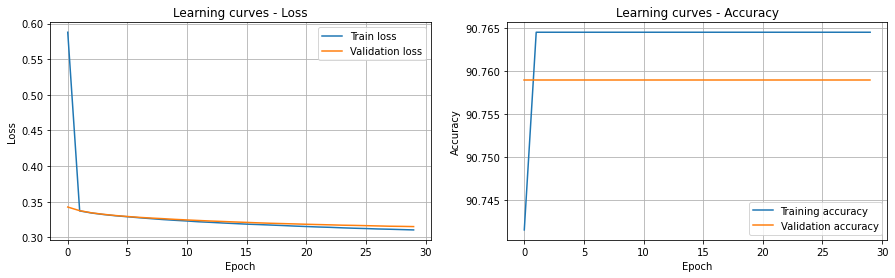

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 4, Nh_rec = 1024, Nh-fc = 64-128, act = Softplus, opt = RMSprop, lr = 0.0001, dropout_prob = 0.15



Best val_loss: 0.24208 - train_loss: 0.22642 - val_acc: 90.76% - train_acc: 91.09% - balanced_accuracy: 0.50% - execution_time: 241s


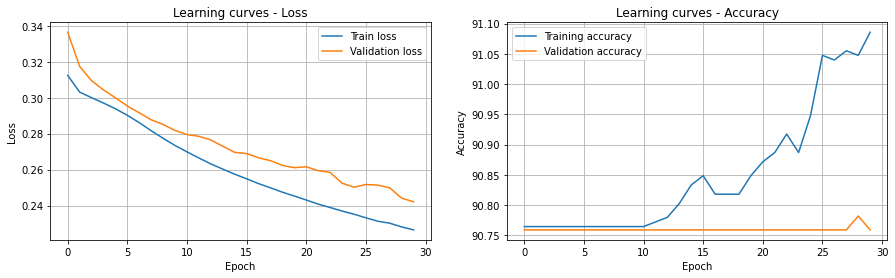

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 4, Nh_rec = 256, Nh-fc = 512-256-256, act = LeakyReLU, opt = RMSprop, lr = 0.0001, dropout_prob = 0.3



Best val_loss: 0.21462 - train_loss: 0.19461 - val_acc: 92.04% - train_acc: 92.39% - balanced_accuracy: 0.60% - execution_time: 105s


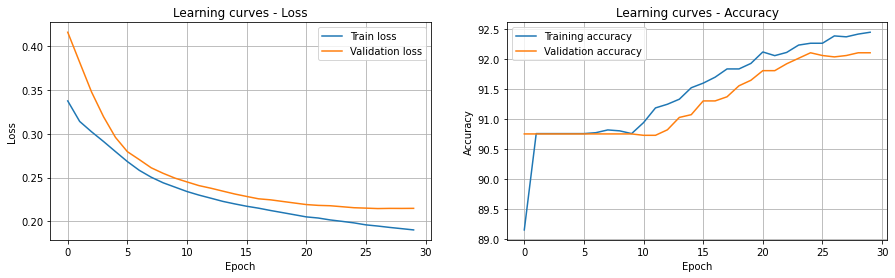

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 1024, Nh-fc = 2048-256-256, act = GELU, opt = SGD, lr = 0.01, dropout_prob = 0.3



Best val_loss: 0.30617 - train_loss: 0.30179 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 192s


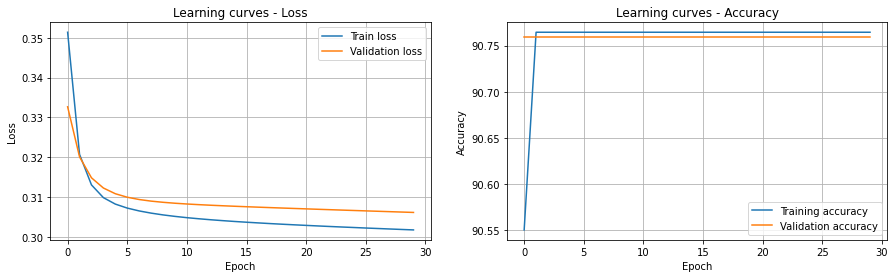

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 1024-1024-1024, act = GELU, opt = Adam, lr = 0.0001, dropout_prob = 0



Best val_loss: 0.20264 - train_loss: 0.16816 - val_acc: 92.96% - train_acc: 93.28% - balanced_accuracy: 0.67% - execution_time: 101s


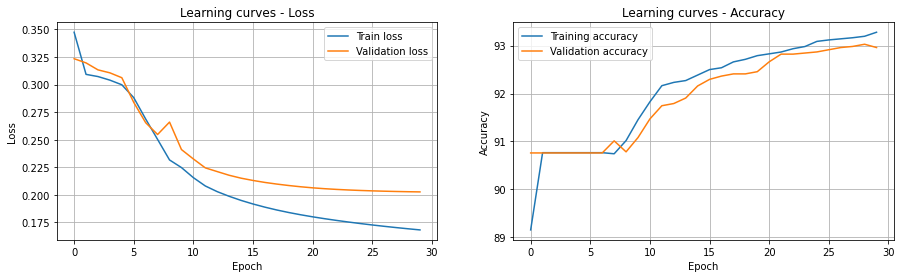

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 1, RL = 1, Nh_rec = 2048, Nh-fc = 64, act = Softplus, opt = Adam, lr = 1, dropout_prob = 0.3


Best val_loss: 0.30716 - train_loss: 27.49162 - val_acc: 90.76% - train_acc: 87.89% - balanced_accuracy: 0.50% - execution_time: 28s


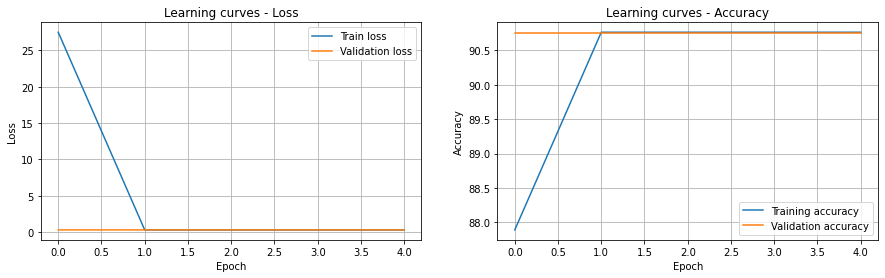

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 1, RL = 4, Nh_rec = 256, Nh-fc = 512, act = Softplus, opt = SGD, lr = 1, dropout_prob = 0.15


Best val_loss: 0.30975 - train_loss: 0.30816 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 35s


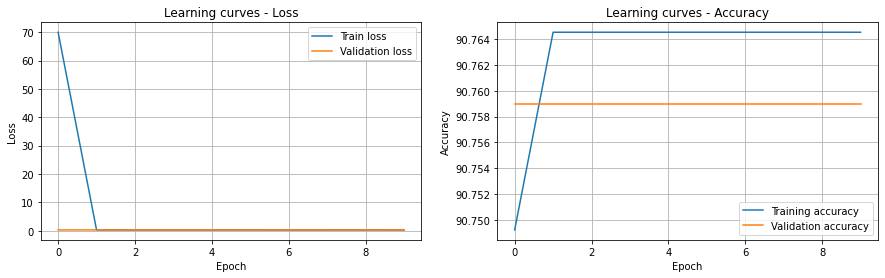

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 1, RL = 2, Nh_rec = 512, Nh-fc = 512, act = ELU, opt = Adam, lr = 0.0001, dropout_prob = 0.3



Best val_loss: 0.22177 - train_loss: 0.20099 - val_acc: 91.47% - train_acc: 92.22% - balanced_accuracy: 0.56% - execution_time: 107s


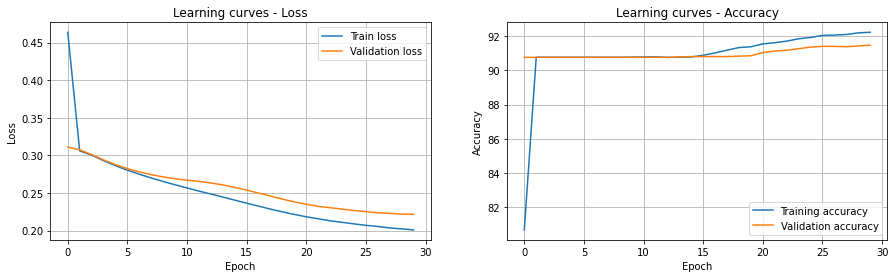

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 3, Nh_rec = 1024, Nh-fc = 64-512, act = Sigmoid, opt = Adam, lr = 0.0001, dropout_prob = 0.15


Best val_loss: 0.30675 - train_loss: 0.30865 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 51s


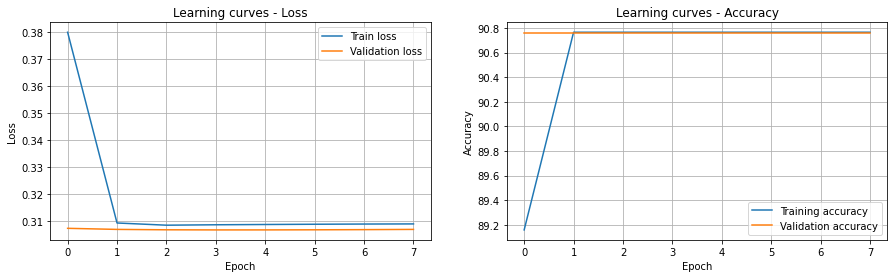

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 512-256-256, act = ELU, opt = Adam, lr = 0.0001, dropout_prob = 0.3



Best val_loss: 0.20961 - train_loss: 0.18098 - val_acc: 92.66% - train_acc: 92.94% - balanced_accuracy: 0.66% - execution_time: 94s


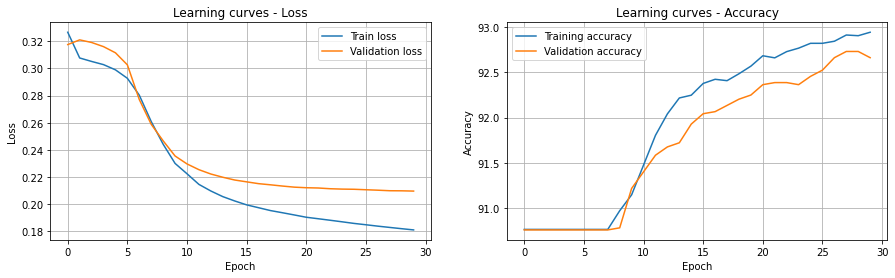

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 3, Nh_rec = 64, Nh-fc = 256-128, act = LeakyReLU, opt = Adam, lr = 0.001, dropout_prob = 0


Best val_loss: 0.23297 - train_loss: 0.23411 - val_acc: 91.01% - train_acc: 90.96% - balanced_accuracy: 0.53% - execution_time: 25s


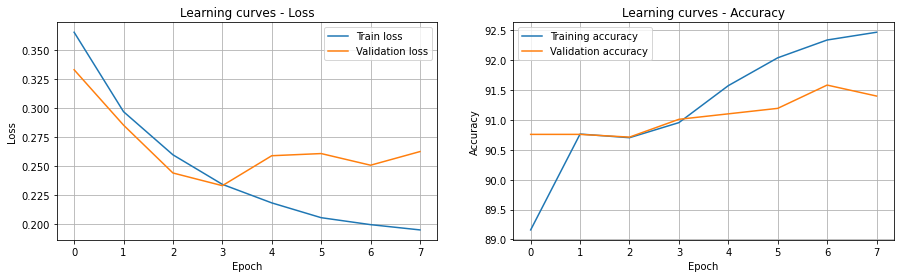

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 3, Nh_rec = 256, Nh-fc = 128-128, act = ELU, opt = RMSprop, lr = 0.001, dropout_prob = 0.3



Best val_loss: 0.21265 - train_loss: 0.16699 - val_acc: 92.52% - train_acc: 93.07% - balanced_accuracy: 0.61% - execution_time: 100s


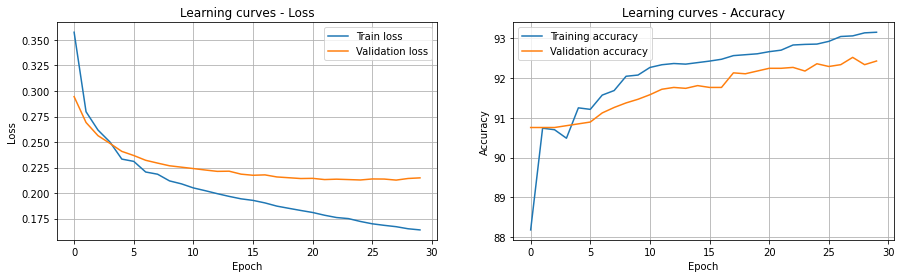

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 1, Nh_rec = 1024, Nh-fc = 1024-128-128, act = Softplus, opt = RMSprop, lr = 0.001, dropout_prob = 0


Best val_loss: 0.23140 - train_loss: 0.21706 - val_acc: 91.19% - train_acc: 91.48% - balanced_accuracy: 0.53% - execution_time: 59s


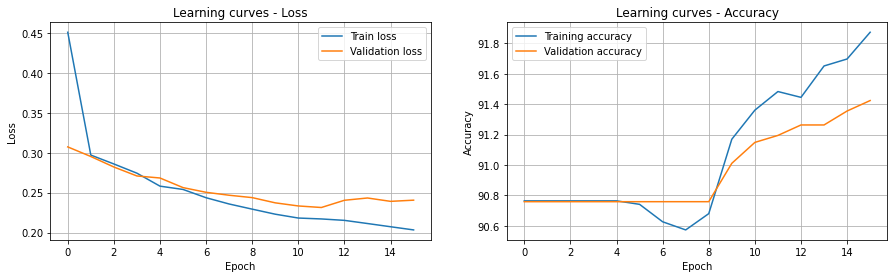

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 2, Nh_rec = 64, Nh-fc = 1024-128, act = GELU, opt = RMSprop, lr = 0.001, dropout_prob = 0.15


Best val_loss: 0.20370 - train_loss: 0.16892 - val_acc: 92.41% - train_acc: 93.26% - balanced_accuracy: 0.61% - execution_time: 62s


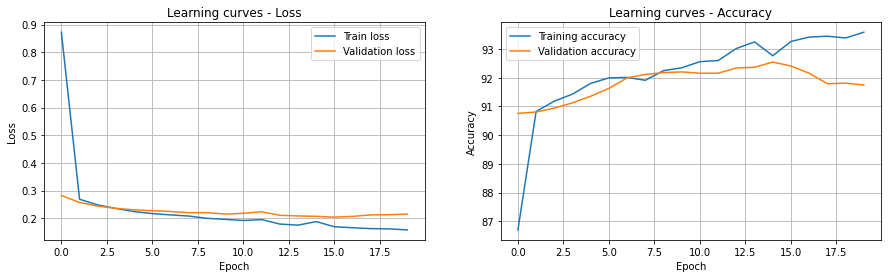

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 512, Nh-fc = 1024-2048-2048, act = LeakyReLU, opt = RMSprop, lr = 0.0001, dropout_prob = 0.15


Best val_loss: 0.22151 - train_loss: 0.18722 - val_acc: 92.32% - train_acc: 92.52% - balanced_accuracy: 0.61% - execution_time: 126s


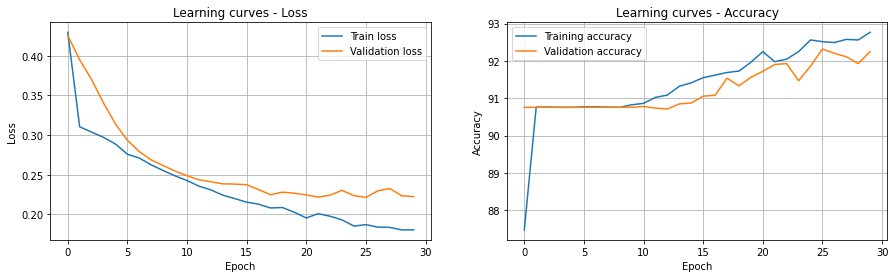

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 1, RL = 3, Nh_rec = 1024, Nh-fc = 2048, act = ELU, opt = SGD, lr = 1, dropout_prob = 0


Best val_loss: 27.61300 - train_loss: 171.92984 - val_acc: 90.76% - train_acc: 83.14% - balanced_accuracy: 0.50% - execution_time: 48s


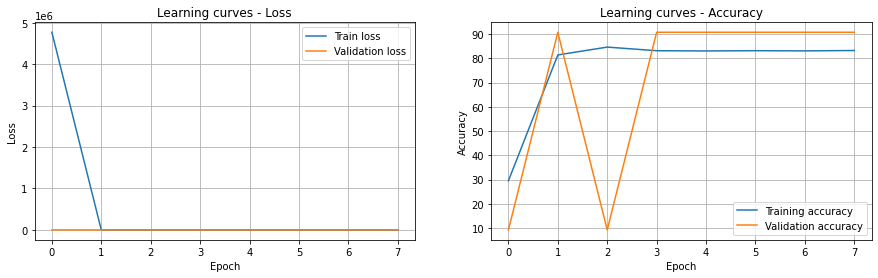

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 1, RL = 2, Nh_rec = 128, Nh-fc = 512, act = LeakyReLU, opt = SGD, lr = 0.0001, dropout_prob = 0



Best val_loss: 0.34308 - train_loss: 0.33981 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 90s


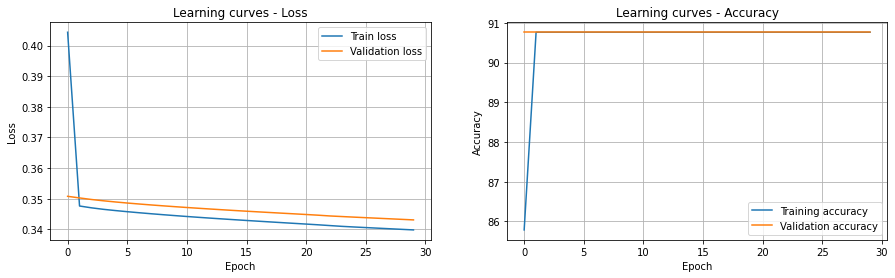

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 3, Nh_rec = 512, Nh-fc = 256-1024, act = Softplus, opt = SGD, lr = 0.0001, dropout_prob = 0



Best val_loss: 0.30649 - train_loss: 0.30648 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 112s


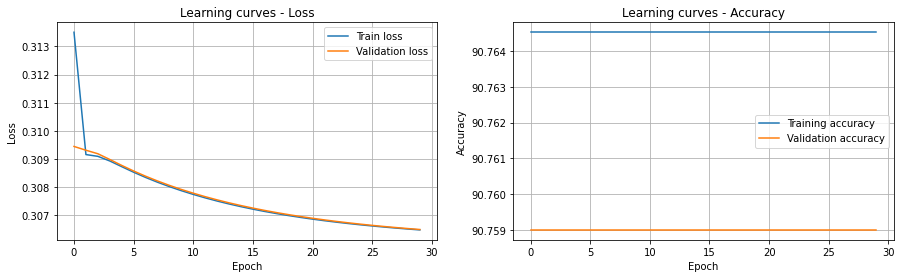

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 1, RL = 1, Nh_rec = 256, Nh-fc = 128, act = ELU, opt = SGD, lr = 0.001, dropout_prob = 0



Best val_loss: 0.30452 - train_loss: 0.30273 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 89s


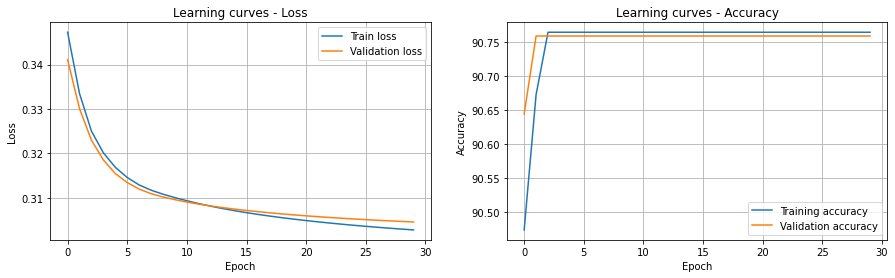

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 4, Nh_rec = 128, Nh-fc = 512-1024-1024, act = LeakyReLU, opt = SGD, lr = 1, dropout_prob = 0.15


RuntimeError: ignored

In [ ]:
# Define possible values for each hyper-parameter
HL_v = [1, 2, 3]
rec_layers_v = [1, 2, 3, 4]
Nh_v = [64, 128, 256, 512, 1024, 2048]
act_v = ['Sigmoid', 'LeakyReLU', 'ELU', 'GELU', 'Softplus']
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU(), 'GELU':nn.GELU(), 'Softplus':nn.Softplus()}
opt_v = ['Adam', 'RMSprop', 'SGD']
lr_v = [1, 0.01, 0.001, 0.0001]
dropout_prob_v =  [0, 0.15, 0.3]
# reg_v = ['False', 'Dropout', 'Batch norm', 'L2']
# wd_v = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# train_batch_size_v = [100, 250, 500, 1000]

max_features_v = [250, 1000, 1900, 2703, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
# vect_type_v = ['cv', 'tfidf']
# approach_v = ['none', 'over', 'under', 'mid']

# max_features = 250
# n_min = 1 # , 2, 3]
# n_max = 1
# vect_type = 'cv'#, 'tfidf']
# approach = 'none'

results = []

# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 30, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(HL_v, rec_layers_v, Nh_v, Nh_v, Nh_v, act_v, opt_v, lr_v, dropout_prob_v))
for (HL, rec_layers, Nh_rec, Nh1, Nh3, act, opt, lr, dropout_prob) in random.sample(random_coarse_grid, 30):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    Nh2 = Nh3
    print(f'RNN with HL = {HL}, RL = {rec_layers}, Nh_rec = {Nh_rec}, Nh-fc = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f' dropout_prob = {dropout_prob}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    # input_size, Nh_rec, Nh1, Nh2, Nh3, No, rec_layers, dropout_prob=0, hidden_layers, activation, reg
    net = RNN( 1, Nh_rec, Nh1, Nh2, Nh3, 2, rec_layers, dropout_prob, HL, activation)
    # net = FCNet(max_features, Nh, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    # X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    # X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    # train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    # val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    # train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    # val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 30
    patience = 4
    # train_dataloader, val_dataloader = myDataLoader(train_dataset, val_dataset, tbs, val_batch_size=250)
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'RNN with HL = {HL}, RL = {rec_layers}, Nh_rec = {Nh_rec}, Nh-fc = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f'dropout_prob = {dropout_prob}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

#### Best networks

RNN with HL = 3, RL = 4, Nh_rec = 256, Nh-fc = 512-256-256, act = LeakyReLU, opt = RMSprop, lr = 0.0001, dropout_prob = 0.3


Best val_loss: 0.21479 - train_loss: 0.18952 - val_acc: 92.16% - train_acc: 92.45% - balanced_accuracy: 0.60% - execution_time: 131s


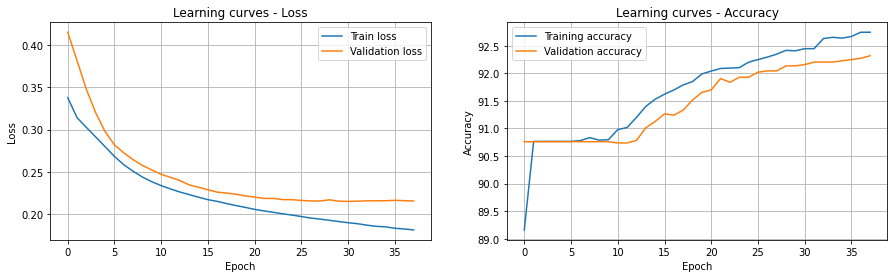

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 1024-1024-1024, act = GELU, opt = Adam, lr = 0.0001, dropout_prob = 0


Best val_loss: 0.20252 - train_loss: 0.16616 - val_acc: 92.98% - train_acc: 93.33% - balanced_accuracy: 0.68% - execution_time: 128s


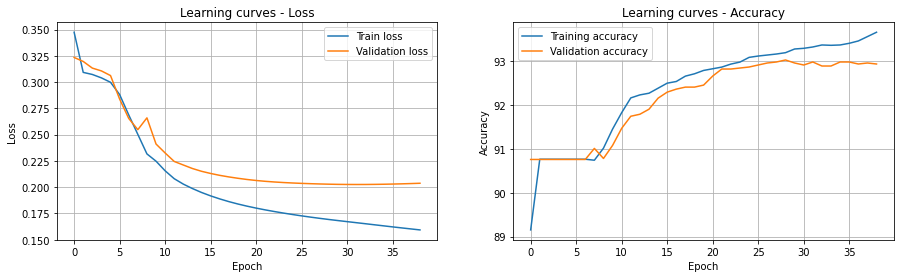

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 512-256-256, act = ELU, opt = Adam, lr = 0.0001, dropout_prob = 0.3


Best val_loss: 0.20836 - train_loss: 0.17446 - val_acc: 92.71% - train_acc: 93.02% - balanced_accuracy: 0.67% - execution_time: 146s


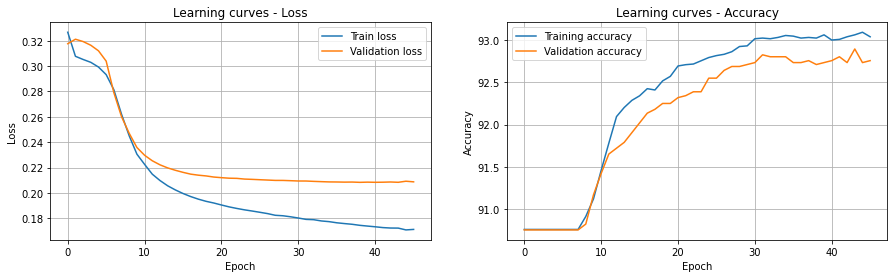

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 2, RL = 3, Nh_rec = 256, Nh-fc = 128-128, act = ELU, opt = RMSprop, lr = 0.001, dropout_prob = 0.3


Best val_loss: 0.20931 - train_loss: 0.17959 - val_acc: 92.34% - train_acc: 92.76% - balanced_accuracy: 0.60% - execution_time: 94s


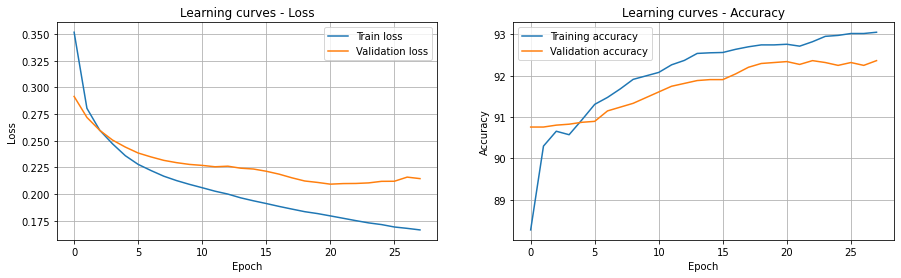

--------------------------------------------------------------------------------------------------------------------
RNN with HL = 3, RL = 3, Nh_rec = 512, Nh-fc = 1024-2048-2048, act = LeakyReLU, opt = RMSprop, lr = 0.0001, dropout_prob = 0.15


Best val_loss: 0.21547 - train_loss: 0.18042 - val_acc: 92.32% - train_acc: 92.63% - balanced_accuracy: 0.61% - execution_time: 143s


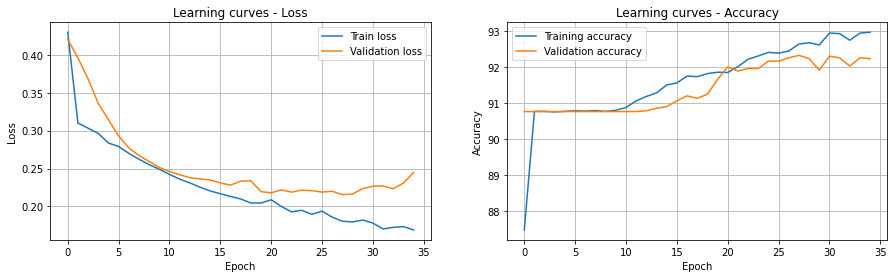

--------------------------------------------------------------------------------------------------------------------
RESULTS SORTED BY ACCURACY
Val_acc = 92.98 - Balanced_val_acc = 0.68 -> RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 1024-1024-1024, act = GELU, opt = Adam, lr = 0.0001,dropout_prob = 0
Val_acc = 92.71 - Balanced_val_acc = 0.67 -> RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 512-256-256, act = ELU, opt = Adam, lr = 0.0001,dropout_prob = 0.3
Val_acc = 92.34 - Balanced_val_acc = 0.60 -> RNN with HL = 2, RL = 3, Nh_rec = 256, Nh-fc = 128-128, act = ELU, opt = RMSprop, lr = 0.001,dropout_prob = 0.3
Val_acc = 92.32 - Balanced_val_acc = 0.61 -> RNN with HL = 3, RL = 3, Nh_rec = 512, Nh-fc = 1024-2048-2048, act = LeakyReLU, opt = RMSprop, lr = 0.0001,dropout_prob = 0.15
Val_acc = 92.16 - Balanced_val_acc = 0.60 -> RNN with HL = 3, RL = 4, Nh_rec = 256, Nh-fc = 512-256-256, act = LeakyReLU, opt = RMSprop, lr = 0.0001,dropout_prob = 0.3
RESULTS SORTED BY BALANCED ACCURACY
Val

In [ ]:
# Define possible values for each hyper-parameter
HL_v = [1, 2, 3]
rec_layers_v = [1, 2, 3, 4]
Nh_v = [64, 128, 256, 512, 1024, 2048]
act_v = ['Sigmoid', 'LeakyReLU', 'ELU', 'GELU', 'Softplus']
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU(), 'GELU':nn.GELU(), 'Softplus':nn.Softplus()}
opt_v = ['Adam', 'RMSprop', 'SGD']
lr_v = [1, 0.01, 0.001, 0.0001]
dropout_prob_v =  [0, 0.15, 0.3]
# reg_v = ['False', 'Dropout', 'Batch norm', 'L2']
# wd_v = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# train_batch_size_v = [100, 250, 500, 1000]

max_features_v = [250, 1000, 1900, 2703, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
# vect_type_v = ['cv', 'tfidf']
# approach_v = ['none', 'over', 'under', 'mid']

# max_features = 250
# n_min = 1 # , 2, 3]
# n_max = 1
# vect_type = 'cv'#, 'tfidf']
# approach = 'none'

best_rnn = [[3, 4, 256, 512, 256, 'LeakyReLU', 'RMSprop', 0.0001, 0.3],
            [3, 3, 128, 1024, 1024, 'GELU', 'Adam', 0.0001, 0],
            [3, 3, 128, 512, 256, 'ELU', 'Adam', 0.0001, 0.3],
            [2, 3, 256, 128, 128, 'ELU', 'RMSprop', 0.001, 0.3],
            [3, 3, 512, 1024, 2048, 'LeakyReLU', 'RMSprop', 0.0001, 0.15]
            ]

results = []

# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 5, desc = 'Random search progress')
for (HL, rec_layers, Nh_rec, Nh1, Nh3, act, opt, lr, dropout_prob) in best_rnn:
    # sampling combinations from itertools.product, we are sure no combination is repeated
    Nh2 = Nh3
    print(f'RNN with HL = {HL}, RL = {rec_layers}, Nh_rec = {Nh_rec}, Nh-fc = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f' dropout_prob = {dropout_prob}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    # input_size, Nh_rec, Nh1, Nh2, Nh3, No, rec_layers, dropout_prob=0, hidden_layers, activation, reg
    net = RNN( 1, Nh_rec, Nh1, Nh2, Nh3, 2, rec_layers, dropout_prob, HL, activation)
    # net = FCNet(max_features, Nh, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    # X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    # X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    # train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    # val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    # train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    # val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 50
    patience = 7
    # train_dataloader, val_dataloader = myDataLoader(train_dataset, val_dataset, tbs, val_batch_size=250)
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'RNN with HL = {HL}, RL = {rec_layers}, Nh_rec = {Nh_rec}, Nh-fc = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f'dropout_prob = {dropout_prob}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

#### Test set evaluation

In [ ]:
# Val_acc = 92.98 - Balanced_val_acc = 0.68 -> RNN with HL = 3, RL = 3, Nh_rec = 128, Nh-fc = 1024-1024-1024, act = GELU, opt = Adam, lr = 0.0001,dropout_prob = 0

(HL, rec_layers, Nh_rec, Nh1, Nh3, act, opt, lr, 
 dropout_prob) = [3, 3, 128, 1024, 1024, 'GELU', 'Adam', 0.0001, 0]
Nh2 = Nh1

random.seed(1)

start_time = time.time()
# NETWORK INITIALIZATION
torch.manual_seed(0)
activation = act_dict[act]
net = RNN(1, Nh_rec, Nh1, Nh2, Nh3, 2, rec_layers, dropout_prob, HL, activation)
net.to(device)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = lr)


# TRAINING LOOP
start_time = time.time()

train_loss_log = []; val_loss_log = []
train_accuracy_log = []; val_accuracy_log = []

for epoch_num in tq.tqdm(range(31), desc = f'Training'):

    # ----------- TRAIN -----------
    train_loss= []
    all_outputs, all_labels = [], []
    net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
    for sample_batched in train_dataloader:
        
        # Move data to device
        x_batch = sample_batched[0].to(device)
        feat_batch = sample_batched[1]
        label_batch = sample_batched[2].to(device)

        # Forward pass
        out = net(x_batch, feat_batch)
        
        # Compute loss
        loss = loss_function(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss and output for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)

    train_accuracy = accuracy(all_outputs, all_labels)
    train_accuracy_log.append(train_accuracy)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)
    

    # # ----------- VALIDATION -----------
    val_loss, all_outputs_v, all_labels_v = validation(test_dataloader, net)
    # print(val_loss)
    val_loss_log.append(val_loss)

    val_accuracy = accuracy(all_outputs_v, all_labels_v)
    # print(val_accuracy)
    val_accuracy_log.append(val_accuracy)
        

 
run_time_rf_fit = time.time() - start_time


In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
start_time = time.time()
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    
    # Move data to device
    x_batch = sample_batched[0].to(device)
    feat_batch = sample_batched[1]
    label_batch = sample_batched[2].to(device)

    # Forward pass
    out = net(x_batch, feat_batch)

    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
# all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)
run_time_rf_predict = (time.time() - start_time)

# test_loss = loss_function(all_outputs, all_labels)
# print(f"AVERAGE TEST LOSS: {test_loss}")
# tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
# test_accuracy = 100 * tot_correct_out / len(all_labels)
# print(f"TEST ACCURACY: {test_accuracy:.2f}%")

In [ ]:
print(f'Fitting running time: {run_time_rf_fit:0.4} s.')
print(f'Predicting running time: {run_time_rf_predict:0.4} s.')
print(f'Total running time: {run_time_rf_fit+run_time_rf_predict:0.4} s.')

Fitting running time: 202.9 s.
Predicting running time: 16.5 s.
Total running time: 219.4 s.


In [ ]:
# # train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
# # train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
# test_acc = (1.0 * (all_outputs.argmax(dim=-1) == all_labels)).mean()
# test_bacc = balanced_accuracy_score(all_labels.cpu(), all_outputs.argmax(dim=-1).cpu())
# # print(f'Accuracy on training + validation set: {train_acc_rf}')
# # print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
# print(f'Test accuracy: {test_acc:.3}')
# print(f'Test balanced accuracy: {test_bacc:.3}')

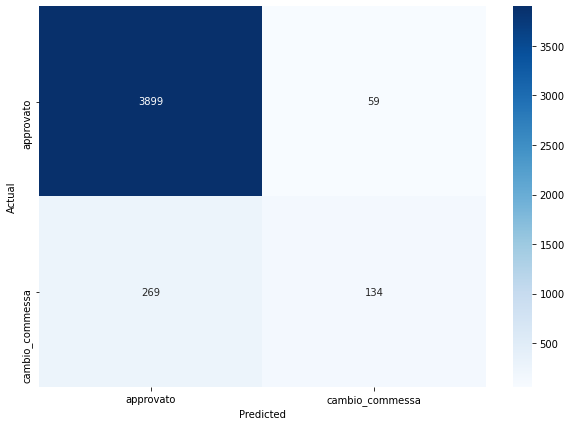

In [ ]:
# Test set
conf_mat = confusion_matrix(all_labels.cpu(), all_outputs.argmax(dim=-1).cpu())
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix, metric_results = metrics_results(np.array(all_labels.cpu()), np.array(all_outputs.argmax(dim=-1).cpu()))
print('CLASSIFICATION METRICS')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.925
Weighted accuracy: 0.659
Precision: 0.694
Sensitivity: 0.333
Specificity: 0.985
MCC: 0.447
F-score: 0.45
